Define the device:

In [1]:
import os
import torch
import warnings
warnings.filterwarnings('ignore')

gpu_list = [0]
gpu_list_str = ','.join(map(str, gpu_list))
os.environ.setdefault("CUDA_VISIBLE_DEVICES", gpu_list_str)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Define the `Hist2Cell` model:

In [2]:
from torch.nn import Linear
import torch.nn as nn
import torchvision.models as models
from torch_geometric.nn import GATv2Conv, LayerNorm
import sys,os
sys.path.append(os.path.dirname(os.getcwd()))
from model.ViT import Mlp, VisionTransformer


class Hist2Cell(nn.Module):
    def __init__(self, cell_dim=39, vit_depth=3):
        super(Hist2Cell, self).__init__()
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet18 = torch.nn.Sequential(*list(self.resnet18.children())[:-1])
        
        self.embed_dim = 32 * 8
        self.head = 8
        self.dropout = 0.3
        
        self.conv1 = GATv2Conv(in_channels=512, out_channels=int(self.embed_dim/self.head), heads=self.head)
        self.norm1 = LayerNorm(in_channels=self.embed_dim)
        
        self.cell_transformer = VisionTransformer(num_classes=cell_dim, embed_dim=self.embed_dim, depth=vit_depth,
                                                  mlp_head=True, drop_rate=self.dropout, attn_drop_rate=self.dropout)
        self.spot_fc = Linear(in_features=512, out_features=256)
        self.spot_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
        self.local_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
        self.fused_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
    
    
    def forward(self, x, edge_index):
        x_spot = self.resnet18(x)
        x_spot = x_spot.squeeze()
        x_local = self.conv1(x=x_spot, edge_index=edge_index)
        x_local = self.norm1(x_local)
        
        x_local = x_local.unsqueeze(0)
        
        x_cell = x_local
        
        x_spot = self.spot_fc(x_spot)
        cell_predication_spot = self.spot_head(x_spot)
        x_local = x_local.squeeze(0)
        cell_prediction_local = self.local_head(x_local)
        cell_prediction_global, x_global = self.cell_transformer(x_cell)
        cell_prediction_global = cell_prediction_global.squeeze()
        x_global = x_global.squeeze()
        cell_prediction_fused = self.fused_head((x_spot+x_local+x_global)/3.0)
        cell_prediction = (cell_predication_spot + cell_prediction_local + cell_prediction_global + cell_prediction_fused) / 4.0
            
        cell_prediction = torch.relu(cell_prediction)
        
        return cell_prediction

Load the checkpoint weights in the Leave-A50-out experiments for human lung cell2location dataset:

In [3]:
case = "A50"

model = Hist2Cell(vit_depth=3)
checkpoint = torch.load("../model_weights/Breast_cancer_epoch3.pth")
model.load_state_dict(checkpoint)
model = model.to(device)

Load test split file, there are 2 slides from donor A50 in humanlung cell2location dataset: 
- WSA_LngSP9258463
- WSA_LngSP9258467

In [4]:
test_slides = open("../train_test_splits/humanlung_cell2location/test_leave_New.txt").read().split('\n')
test_slides

['tissue_hires_image']

Load and create the `Dataloader` for the processed data of each slide, save the predictions and calculate the pearson R for 80 fine-grained cell types:

In [5]:
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import torch_geometric
torch_geometric.typing.WITH_PYG_LIB = False
from torch_geometric.data import Batch
import numpy as np
from scipy.stats import pearsonr


hop = 2
subgraph_bs = 16
test_graph_list = list()
for item in test_slides:
    test_graph_list.append(torch.load(os.path.join("../patch/output", item+'.pt')))
test_dataset = Batch.from_data_list(test_graph_list)

test_loader = NeighborLoader(
    test_dataset,
    num_neighbors=[-1]*hop,
    batch_size=subgraph_bs,
    directed=False,
    input_nodes=None,
    shuffle=False,
    num_workers=0,
)

with torch.no_grad():
    model.eval()
    test_cell_pred_array = []
    test_cell_label_array = []
    test_cell_pos_array = []
    for graph in tqdm(test_loader):
        x = graph.x.to(device)
        y = graph.y.to(device)
        pos = graph.pos.to(device)
        edge_index = graph.edge_index.to(device)
        cell_label = y[:, 250:]
        cell_pred = model(x=x, edge_index=edge_index)
        center_num = len(graph.input_id)
        center_cell_label = cell_label[:center_num, :]
        center_cell_pred = cell_pred[:center_num, :]
        center_cell_pos = pos[:center_num, :]
        test_cell_label_array.append(center_cell_label.squeeze().cpu().detach().numpy())
        test_cell_pred_array.append(center_cell_pred.squeeze().cpu().detach().numpy())
        test_cell_pos_array.append(center_cell_pos.squeeze().cpu().detach().numpy())
        
    
    if len(test_cell_pred_array[-1].shape) == 1:
        test_cell_pred_array[-1] = np.expand_dims(test_cell_pred_array[-1], axis=0)
    test_cell_pred_array = np.concatenate(test_cell_pred_array)
    if len(test_cell_label_array[-1].shape) == 1:
        test_cell_label_array[-1] = np.expand_dims(test_cell_label_array[-1], axis=0)
    test_cell_label_array = np.concatenate(test_cell_label_array)
    if len(test_cell_pos_array[-1].shape) == 1:
        test_cell_pos_array[-1] = np.expand_dims(test_cell_pos_array[-1], axis=0)
    test_cell_pos_array = np.concatenate(test_cell_pos_array)
    

Predictions = dict()
R_all = []
for slide_no in range(len(test_slides)):
    
    indices = np.where(test_dataset.batch.numpy() == slide_no)
    test_cell_pred_array_sub = test_cell_pred_array[indices]
    test_cell_label_array_sub = test_cell_label_array[indices]
    test_cell_pos_arraay_sub = test_cell_pos_array[indices]

    test_cell_abundance_all_pearson_average = 0.0
    test_cell_pearson_list = []
    # for i in range(test_cell_pred_array_sub.shape[1]):
    #     r, p = pearsonr(test_cell_pred_array_sub[:, i], test_cell_label_array_sub[:, i])
    #     test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average + r
    #     test_cell_pearson_list.append(r)
    # test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average / test_cell_pred_array_sub.shape[1]
    num = 0
    R = []
    for i in range(test_cell_pred_array_sub.shape[1]):
        r, p = pearsonr(test_cell_pred_array_sub[:, i], test_cell_label_array_sub[:, i])
        R.append(r)
        if not np.isnan(r):
         num+=1
         test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average + r
         test_cell_pearson_list.append(r)
    test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average / num
    Predictions[test_slides[slide_no]] = {
        'cell_abundance_predictions': test_cell_pred_array_sub,
        'cell_abundance_labels': test_cell_label_array_sub,
        'coords': test_cell_pos_arraay_sub,
    }
    R_all.append(R)
    
    
    print("slide %s has PCC:%f" % (test_slides[slide_no], test_cell_abundance_all_pearson_average)) 

100%|██████████| 158/158 [00:04<00:00, 32.87it/s]

slide tissue_hires_image has PCC:0.035256


In [17]:
print(Predictions["H1"]["cell_abundance_labels"])
print(Predictions["H1"]["coords"])
print(Predictions["H1"]["spot_id"])

KeyError: 'H1'

In [6]:
print(R_all)
def sort_numbers_with_indices(numbers):
    indexed_numbers = list(enumerate(numbers))
    sorted_indexed_numbers = sorted(indexed_numbers, key=lambda x: x[1])
    sorted_dict = {i: num for i, num in sorted_indexed_numbers}
    return sorted_dict
sorted_indexed_numbers_H1 = sort_numbers_with_indices(R_all[0])

print(sorted_indexed_numbers_H1)

[[0.08414460652685787, 0.07778589330131302, 0.046104759761749235, -0.01112425977450893, -0.00037040687785723107, -0.12878043776499604, 0.009756033147453757, 0.140175085972717, -0.1744345888656168, 0.132572447327309, 0.16104039221448407, 0.1299872577623919, 0.06650338266160048, 0.1302018635640847, 0.012509666010682737, 0.13789698979877016, 0.20752649245409, 0.027286778135592913, 0.15887109445058442, -0.005709903942284176, -0.05861355246370607, -0.02839296370566568, 0.1581899344255747, -0.02920360460292728, -0.17802104287097648, -0.014120473061822937, 0.1692179349218827, 0.007653838356434009, 0.07875249062011597, 0.048544383268579426, 0.06406997208741204, -0.21288362115697868, -0.022968169507499546, -0.01140887153392086, -0.004533846155912607, 0.10264277436426779, 0.0117033790721503, 0.15895711478917354, -0.06655245240453644]]
{31: -0.21288362115697868, 24: -0.17802104287097648, 8: -0.1744345888656168, 5: -0.12878043776499604, 38: -0.06655245240453644, 20: -0.05861355246370607, 23: -0.02

In [7]:
visualize_cell_names = ['luminal epithelial cell of mammary gland', 'fibroblast', 'pericyte']

In [22]:
import joblib
import pandas as pd
cell_types = joblib.load("../example_data/humanlung_cell2location/cell_types_brast_cancer.pkl")
cell_name = []
cell_score = []
for i in range(len(cell_types)):
 cell_name.append(cell_types[i])
 cell_score.append(sorted_indexed_numbers_H1[i]) 

df = pd.DataFrame({
    'Cell Name': cell_name,
    'Cell Score': cell_score
})

# Export to CSV
df.to_csv('../patch/output/data.csv', index=False)


In [10]:
import pandas as pd
import joblib
df = pd.DataFrame(test_cell_pred_array_sub)
new_row = joblib.load("../patch/cell_types.pkl")
new_row = pd.DataFrame([new_row])

df = pd.concat([new_row, df], ignore_index=True)
new_column_df = pd.read_csv('../patch/visium_ductal_breast_ground_truth-cell2locationPopulations_aligned.csv', header=None)

new_column = new_column_df.iloc[:, 0]
new_column_df = pd.DataFrame(new_column)
df = pd.concat([new_column_df, df], axis=1)
df.to_csv('../patch/output/prediction_results.csv', index=False)

In [48]:
result = pd.DataFrame(R).transpose()
df = pd.concat([new_row, result], ignore_index=True)
df.to_csv('../patch/output/Pearson_result.csv', index=False)

In [9]:
import numpy as np
import csv
import pandas as pd
print(test_cell_pred_array_sub)
print(len(test_cell_label_array_sub))
print(test_cell_abundance_all_pearson_average)


with open('../patch/V10T03-282-A1/prediction.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(test_cell_pred_array_sub)
# 输出相关矩阵


[[0.02671983 0.         0.         ... 0.04631003 0.         0.        ]
 [0.02671983 0.         0.         ... 0.04631003 0.         0.        ]
 [0.02671983 0.         0.         ... 0.04631003 0.         0.        ]
 ...
 [0.02615657 0.         0.         ... 0.04731449 0.         0.        ]
 [0.02615657 0.         0.         ... 0.04731449 0.         0.        ]
 [0.02615657 0.         0.         ... 0.04731449 0.         0.        ]]
2518
0.0015956205882292145


In [22]:
r, p = pearsonr(test_cell_pred_array_sub[:, 1], test_cell_label_array_sub[:, 1])
print(p)


1.3616119050211972e-65


In [32]:
indices = np.where(test_dataset.batch.numpy() == 0)
test_cell_pred_array_sub = test_cell_pred_array[indices]
test_cell_label_array_sub = test_cell_label_array[indices]
test_cell_pos_arraay_sub = test_cell_pos_array[indices]
test_cell_abundance_all_pearson_average = 0.0
test_cell_pearson_list = []
num = 0
r_all = []
matrix = []
for i in range(test_cell_pred_array_sub.shape[1]):
    R = []
    for j in range(test_cell_pred_array_sub.shape[1]):
        r, p = pearsonr(test_cell_pred_array_sub[:, i], test_cell_label_array_sub[:, j])
        R.append(r)
        if not np.isnan(r):
         num+=1
         r_all.append(r)
         test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average + r
         test_cell_pearson_list.append(r)
    matrix.append(R)
test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average / num


PearsonRResult(statistic=0.12650516798017364, pvalue=1.8848082670162496e-10)


IndexError: list index out of range

In [15]:
import csv
with open('../patch/V10T03-282-A1/matrix_part.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(matrix)

In [13]:
Predictions.keys()

dict_keys(['tissue_hires_image'])

Under the prediction of each slide, we have the labels and predictions for the 80 fine-grained cell types of each spot, and the spatial coordinate of each spot:

In [34]:
Predictions['tissue_hires_image'].keys()

dict_keys(['cell_abundance_predictions', 'cell_abundance_labels', 'coords'])

Visualize the predictions of `Hist2Cell` in `Fig 3b`, `Fig 3a` and `Supp Fig 4`.

In [96]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_cell_abundance(img, X, Y, cell_abundance, cell_name, cmap='viridis', s=13):
    fig, ax = plt.subplots()
    #ax.imshow(img.transpose(Image.FLIP_TOP_BOTTOM).transpose(Image.FLIP_LEFT_RIGHT))

    sc = ax.scatter(img.size[0] - (Y ), img.size[0] - (X ),
                    c=cell_abundance,
                    s=s, alpha=0.80, cmap=cmap)

    ax.set_xlim(img.size[0] - (min(Y)-50), img.size[0] - (max(Y)+50))
    ax.set_ylim(img.size[1] - (min(X)-50), img.size[1] - (max(X)+50))
    ax.set_ylim(ax.get_xlim()[::-1])

    ax.set_xticks([])
    ax.set_yticks([])

    cbar = plt.colorbar(sc, ax=ax)

    cbar.ax.tick_params(labelsize=14)
    
    ax.set_title(cell_name, fontsize=16)  
    
    plt.show()

In [89]:
import matplotlib.pyplot as plt
from PIL import Image


def plot_cell_abundance_label(img, X, Y, cell_abundance, cell_name, cmap='viridis', s=13):
    fig, ax = plt.subplots()
    #ax.imshow(img.transpose(Image.FLIP_TOP_BOTTOM).transpose(Image.FLIP_LEFT_RIGHT))

    sc = ax.scatter(img.size[0] - Y, img.size[0] - X,
                    c=cell_abundance,
                    s=s, alpha=0.80, cmap=cmap)

    ax.set_xlim(img.size[0] - (min(Y)-50), img.size[0] - (max(Y)+50))
    ax.set_ylim(img.size[1] - (min(X)-50), img.size[1] - (max(X)+50))
    ax.set_ylim(ax.get_xlim()[::-1])

    ax.set_xticks([])
    ax.set_yticks([])

    cbar = plt.colorbar(sc, ax=ax)

    cbar.ax.tick_params(labelsize=14)
    
    ax.set_title(cell_name + "_label", fontsize=16)  
    
    plt.show()

In [66]:
import csv

# 读取CSV文件
input_file = '../patch/V10T03-282-A1/Cell2Location_1.csv'

with open(input_file, 'r') as file:
    reader = csv.reader(file)
    first_row = next(reader)[1:]

print("第一行数据（使用csv库）：")
print(first_row)

FileNotFoundError: [Errno 2] No such file or directory: '../patch/V10T03-282-A1/Cell2Location_1.csv'

  0%|          | 0/3 [00:00<?, ?it/s]

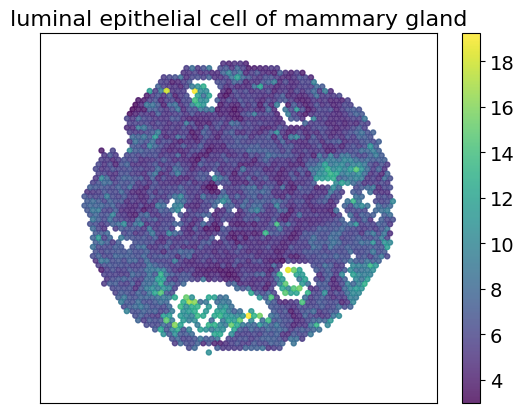

 33%|███▎      | 1/3 [00:00<00:00,  6.14it/s]

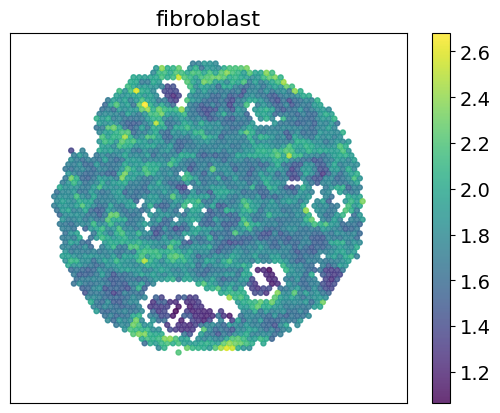

 67%|██████▋   | 2/3 [00:00<00:00,  6.22it/s]

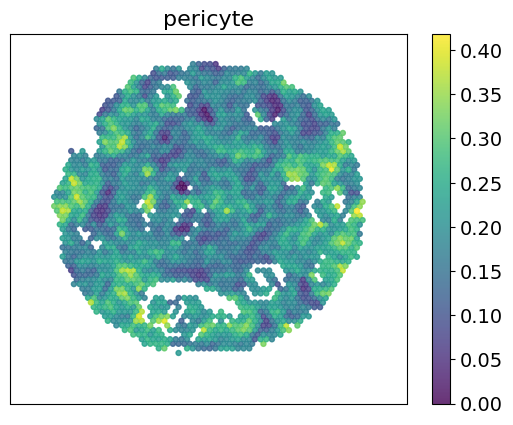

100%|██████████| 3/3 [00:00<00:00,  5.98it/s]


In [97]:
import joblib
from tqdm import tqdm
import csv

slide = "tissue_hires_image"
sc = 0.02185633


cell_types = joblib.load("../example_data/humanlung_cell2location/cell_types_brast_cancer.pkl")

# 指定要可视化的细胞类型名称列表
visualize_cell_names = ['luminal epithelial cell of mammary gland', 'fibroblast', 'pericyte']

#np.clip 限制值在指定范围中
hist2cell_abundances = np.clip(Predictions[slide]['cell_abundance_predictions'], a_min=0, a_max=None)
coordinates = Predictions[slide]['coords']
X = (coordinates[:, 0]/3.3)
Y = (coordinates[:, 1]/3.3)

jpg_path = '../patch/tissue_lowres_image.png'
img = Image.open(jpg_path)


# 遍历可视化的细胞类型并绘制丰度图
for i in tqdm(range(len(visualize_cell_names))):
    cell_idx = cell_types.index(visualize_cell_names[i])
    # 绘制当前细胞类型的丰度图
    plot_cell_abundance(img, X, Y, hist2cell_abundances[:, cell_idx], cell_types[cell_idx], cmap='viridis')

ikkFollow the same steps, we visualize the cell abundance predictions in `Fig 2`:

In [11]:
case = "A37"

model = Hist2Cell(vit_depth=3)
checkpoint = torch.load("../model_weights/humanlung_cell2location_leave_"+case+"_out.pth")
model.load_state_dict(checkpoint)
model = model.to(device)

In [12]:
test_slides = open("../train_test_splits/humanlung_cell2location/test_leave_"+case+".txt").read().split('\n')
test_slides

['WSA_LngSP9258464',
 'WSA_LngSP9258468',
 'WSA_LngSP10193347',
 'WSA_LngSP10193348']

In [91]:
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import torch_geometric
torch_geometric.typing.WITH_PYG_LIB = False
from torch_geometric.data import Batch
import numpy as np
from scipy.stats import pearsonr


hop = 2
subgraph_bs = 16
test_graph_list = list()
for item in test_slides:
    test_graph_list.append(torch.load(os.path.join("../example_data/humanlung_cell2location", item+'.pt')))
# 将数据列表转换为Batch对象，以便进行批处理
test_dataset = Batch.from_data_list(test_graph_list)

test_loader = NeighborLoader(
    test_dataset,
    num_neighbors=[-1]*hop,
    batch_size=subgraph_bs,
    directed=False,
    input_nodes=None,
    shuffle=False,
    num_workers=2,
)

with torch.no_grad():
    model.eval()
    test_cell_pred_array = []
    test_cell_label_array = []
    test_cell_pos_array = []
    for graph in tqdm(test_loader):
        x = graph.x.to(device)
        y = graph.y.to(device)
        pos = graph.pos.to(device)
        edge_index = graph.edge_index.to(device)
        cell_label = y[:, 250:]
        cell_pred = model(x=x, edge_index=edge_index)

        center_num = len(graph.input_id)
        center_cell_label = cell_label[:center_num, :]
        center_cell_pred = cell_pred[:center_num, :]
        center_cell_pos = pos[:center_num, :]
        
        test_cell_label_array.append(center_cell_label.squeeze().cpu().detach().numpy())
        test_cell_pred_array.append(center_cell_pred.squeeze().cpu().detach().numpy())
        test_cell_pos_array.append(center_cell_pos.squeeze().cpu().detach().numpy())
        

    if len(test_cell_pred_array[-1].shape) == 1:
        test_cell_pred_array[-1] = np.expand_dims(test_cell_pred_array[-1], axis=0)
    test_cell_pred_array = np.concatenate(test_cell_pred_array)
    if len(test_cell_label_array[-1].shape) == 1:
        test_cell_label_array[-1] = np.expand_dims(test_cell_label_array[-1], axis=0)
    test_cell_label_array = np.concatenate(test_cell_label_array)
    if len(test_cell_pos_array[-1].shape) == 1:
        test_cell_pos_array[-1] = np.expand_dims(test_cell_pos_array[-1], axis=0)
    test_cell_pos_array = np.concatenate(test_cell_pos_array)
    

Predictions = dict()
for slide_no in range(len(test_slides)):
    indices = np.where(test_dataset.batch.numpy() == slide_no)
    test_cell_pred_array_sub = test_cell_pred_array[indices]
    test_cell_label_array_sub = test_cell_label_array[indices]
    test_cell_pos_arraay_sub = test_cell_pos_array[indices]
    
    test_cell_abundance_all_pearson_average = 0.0
    test_cell_pearson_list = []
    for i in range(test_cell_pred_array_sub.shape[1]):
        r, p = pearsonr(test_cell_pred_array_sub[:, i], test_cell_label_array_sub[:, i])
        test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average + r
        test_cell_pearson_list.append(r)
    test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average / test_cell_pred_array_sub.shape[1]
    
    Predictions[test_slides[slide_no]] = {
        'cell_abundance_predictions': test_cell_pred_array_sub,
        'cell_abundance_labels': test_cell_label_array_sub,
        'coords': test_cell_pos_arraay_sub,
    }
    
    print("slide %s has PCC:%f" % (test_slides[slide_no], test_cell_abundance_all_pearson_average)) 

FileNotFoundError: [Errno 2] No such file or directory: '../example_data/humanlung_cell2location\\tissue_hires_image.pt'

  0%|          | 0/3 [00:00<?, ?it/s]

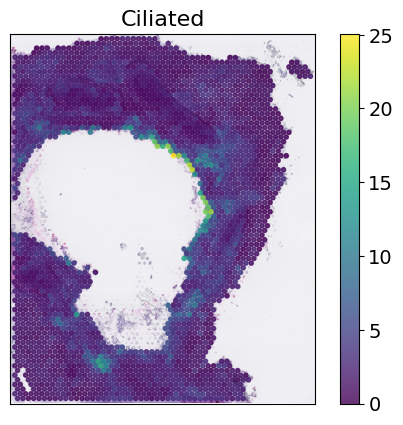

 33%|███▎      | 1/3 [00:03<00:07,  3.60s/it]

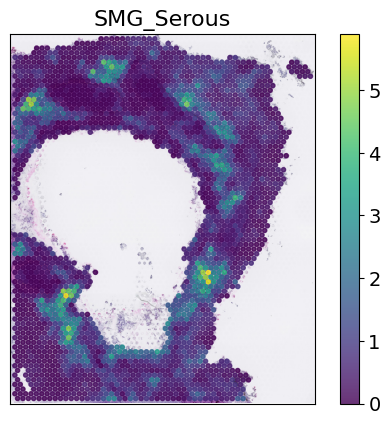

 67%|██████▋   | 2/3 [00:06<00:03,  3.47s/it]

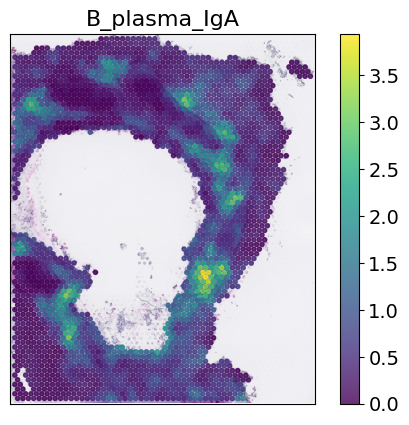

100%|██████████| 3/3 [00:10<00:00,  3.52s/it]


In [15]:
import joblib
from tqdm import tqdm


slide = "WSA_LngSP9258464"

cell_types = joblib.load("../example_data/humanlung_cell2location/cell_types.pkl")
visualize_cell_names = ['Ciliated', 'SMG_Serous',  'B_plasma_IgA']


hist2cell_abundances = np.clip(Predictions[slide]['cell_abundance_predictions'], a_min=0, a_max=None)
coordinates = Predictions[slide]['coords']
X = coordinates[:, 0] / 4
Y = coordinates[:, 1] / 4

jpg_path = '../example_data/humanlung_cell2location/'+slide+'_low_res.jpg'
img = Image.open(jpg_path)


for i in tqdm(range(len(visualize_cell_names))):
    cell_idx = cell_types.index(visualize_cell_names[i])
    plot_cell_abundance(img, X, Y, hist2cell_abundances[:, cell_idx], cell_types[cell_idx], cmap='viridis', s=9)